In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Контекст: 
### Наша компания разрабатывает мобильные игры. У нас есть данные о регистрации и последующих авторизации. Необходимо написать функцию для подсчета метрики Retention Rate по ежедневным когортам. 

In [2]:
# записываю данные в переменные
reg_data = pd.read_csv('data/reg_data.csv', sep=';')
auth_data = pd.read_csv('data/auth_data.csv', sep=';')

## Первичное ознакомление с данными

In [3]:
# считаю количество строк и столбцов в датафреймах
print(f'Количество строк табилице с регистрациями - {reg_data.shape[0]}, количество столбцов {reg_data.shape[1]}')
print(f'Количество строк табилице с авторизациями - {auth_data.shape[0]}, количество столбцов {auth_data.shape[1]}')

Количество строк табилице с регистрациями - 1000000, количество столбцов 2
Количество строк табилице с авторизациями - 9601013, количество столбцов 2


In [4]:
# проверяю типы данных
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
# проверяю типы данных
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [6]:
# вывожу превые пять строк
reg_data.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [7]:
# вывожу превые пять строк
auth_data.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [8]:
# смотрю на количество пропущенных значений
reg_data.isna().sum().to_frame(name='missing_values')

,missing_values
reg_ts,0
uid,0


In [9]:
# смотрю на количество пропущенных значений
auth_data.isna().sum().to_frame(name='missing_values')

,missing_values
auth_ts,0
uid,0


In [10]:
# считаю количество дубликатов
print(f'Количество дубликатов в данных регистраций - {reg_data.duplicated().sum()}') 
print(f'Количество дубликатов в данных авторизаций - {auth_data.duplicated().sum()}')

Количество дубликатов в данных регистраций - 0
Количество дубликатов в данных авторизаций - 0


In [11]:
#количество уникальных id
print(f'Количество уникальных IDs в регистрациях - {reg_data.uid.nunique()}')
print(f'Количество уникальных IDs в авторизациях - {auth_data.uid.nunique()}')

Количество уникальных IDs в регистрациях - 1000000
Количество уникальных IDs в авторизациях - 1000000


## Преобразование данных 

In [12]:
# привожу  unix timestamp к дате
reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.round('d') 
auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.round('d') 

## Разведовательный анализ данных

In [13]:
# считаю количество регистраций за каждый год, до 2010 года число регистраций меньше 1000, фильтую эти записи
reg_data['reg_year'] = reg_data['reg_date'].dt.year
auth_data['reg_year'] = auth_data['auth_date'].dt.year
reg_data.reg_year.value_counts().to_frame('users_number').query("users_number > 1000")

,users_number
reg_year,
2020,355494
2019,290862
2018,159598
2017,87572
2016,48148
2015,26323
2014,14442
2013,7926
2012,4357


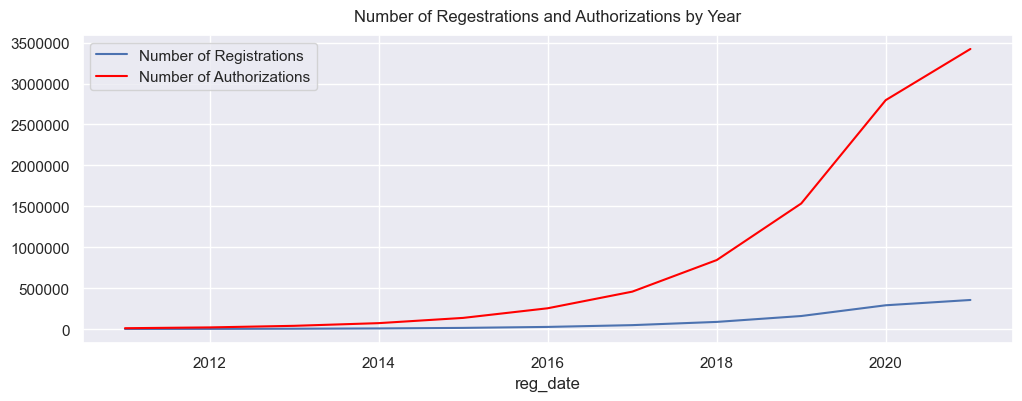

In [14]:
# визуализирую число регистрация и авторизация с помощью линейного графика
plt.figure(figsize=(12, 4))
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)}) # отменяю научную нотацию 
sns.lineplot(reg_data.set_index('reg_date').resample('1YE').count()[['uid']] \
             .rename(columns={'uid': 'Number of Registrations'})['2010-12-31':])
sns.lineplot(auth_data.set_index('auth_date').resample('1YE').count()[['uid']] \
             .rename(columns={'uid': 'Number of Authorizations'})['2010-12-31':],
             palette=['red'])
plt.title('Number of Regestrations and Authorizations by Year', pad=10);

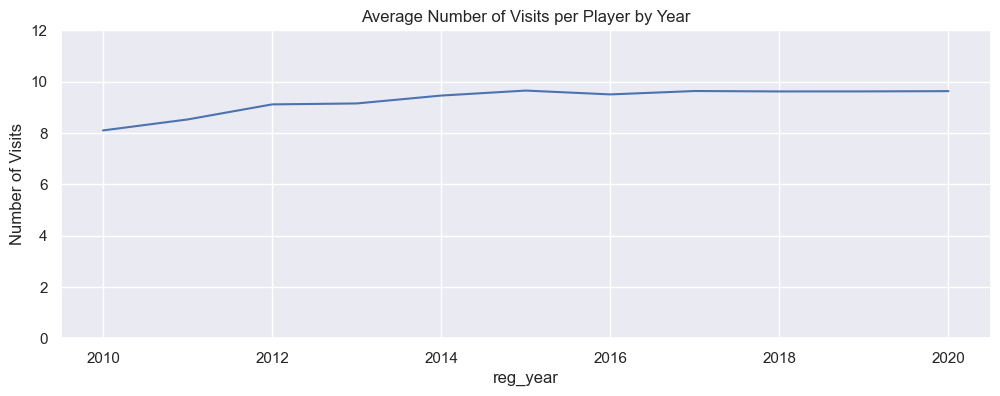

In [15]:
# визуализирую количество авторизаций в игра в среднем за год
plt.figure(figsize=(12, 4))
ax = sns.lineplot((auth_data.loc[auth_data['reg_year'] >= 2010].groupby('reg_year').size() / reg_data.loc[reg_data['reg_year'] >= 2010].groupby('reg_year').size()))
ax.set_ylim(0,12)
ax.set_title('Average Number of Visits per Player by Year')
ax.set_ylabel('Number of Visits');

### Выводы по Разведовательному анализу данных: 
1) Несмотря на значительный видимый рост авторизаций по сравнению с регистрациями, среднее число посещений на игрока стабильно в пределах 8-10

## Функция Retention Rate

In [16]:
def get_retention(reg_data, auth_data, first_date, ndays):
    """
    Calculate the retention rate according to its daily cohort
    Parameters:  
        1) DataFrame with registration 
        2) DataFrame with authrizations  
        3) First day of cohort
        4) Number of days to monitor
    Return:
        - saves DataFrame with Retention Rate 
        - shows heatmap with Retention Rate
    """
    first_date = pd.to_datetime(first_date, format='%Y-%m-%d')  # привожу к формуту даты
    last_date = (pd.to_datetime(first_date) + pd.Timedelta(days=ndays)) # задаю конечную дату
    
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.round('d') 
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.round('d') 
    
    reg_short = reg_data.query('reg_date >= @first_date and reg_date <= @last_date') # фильтрую по датам
    auth_short = auth_data.query('auth_date >= @first_date and auth_date <= @last_date') # фильтрую по датам
    
    
    merged_df = reg_short.merge(auth_short, on='uid', how='left') # объединяю датафреймы
    merged_df = merged_df[['uid', 'reg_date', 'auth_date']] # оставляю необходимые колонки
    
     # создаю колонку с днями авторизации после регистрации
    merged_df['day'] = (merged_df.auth_date - merged_df.reg_date).dt.days 

    # группирую по дате регистрации и дням авторизации, считаю количество уникальных пользователей
    df_final = merged_df.groupby(['reg_date', 'day'], as_index=False).agg(users=('uid', 'nunique'))\
    .pivot_table(index='reg_date', columns='day', values='users')  # составляю на основе датафрейма сводную таблицу
    
    
    cohort_users = df_final.iloc[:,0] # сохраняю количество юзеров в когортах
    
    #делю построчно каждое значение на начальное кол-во юзеров в когорте
    df_final = (df_final.divide(cohort_users, axis=0) * 100).round(2)
    df_final[0] = cohort_users.astype(int) # возвращаю количество юзеров в когорте в таблицу
    df_final = df_final.rename(columns={0: 'users_num'}) # меняю название первой колонки на более понятное
    
    plt.rcParams['font.size'] = '10' #задаю параметр размер шрифта
    plt.figure(figsize=(24, 12)) # задаю параметр размера графика
    
    #строю heatmap с параметрами: показывать значения, основные значения в диапазоне 0-10, 1 цифру после запятой)
    ax = sns.heatmap(data=df_final, annot=True, vmin=0, vmax=10 , cmap='coolwarm', fmt=".1f") 
    ax.set_yticklabels(df_final.index.strftime('%Y-%m-%d'), fontsize = 12) # привожу индексы к формату даты

    ax.set_xlabel('Number of days', fontsize=16) # Именую ось х
    ax.set_ylabel('Cohort date', fontsize=16)  # Именую ось y
    ax.set_title('Retention Rate by Day (%)', fontsize=22, pad=14)  # Задаю заголовок
    ax.xaxis.tick_top()
    plt.savefig('data/Cohort.png',dpi=300)
    plt.show()
    
    #вывожу heatmap, также сохраняю файл в формате csv для возможного последуюшего анализа 
    return ax, df_final.to_csv('data/df_cohort.csv')

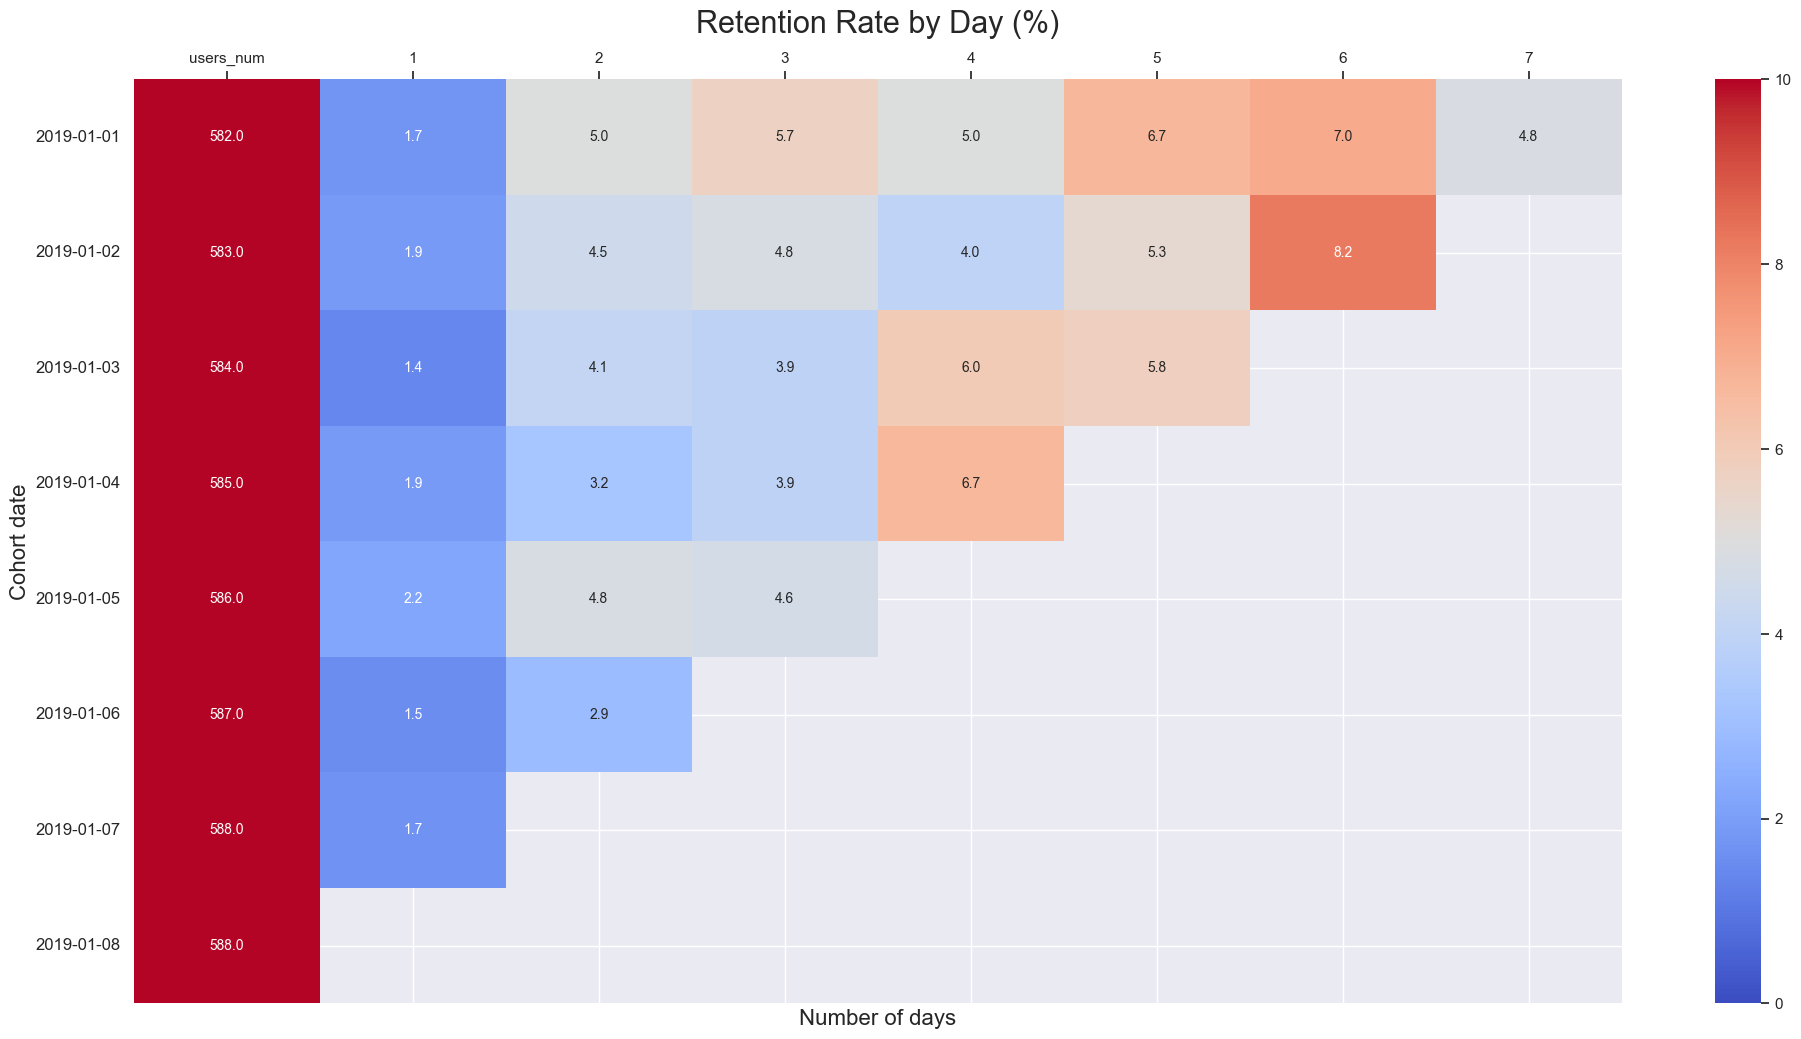

In [17]:
first_date = '2019-01-01' # пишу дату в формате год-месяц-день
ndays = 7 # задаю количество дней 
get_retention(reg_data, auth_data, first_date, ndays);

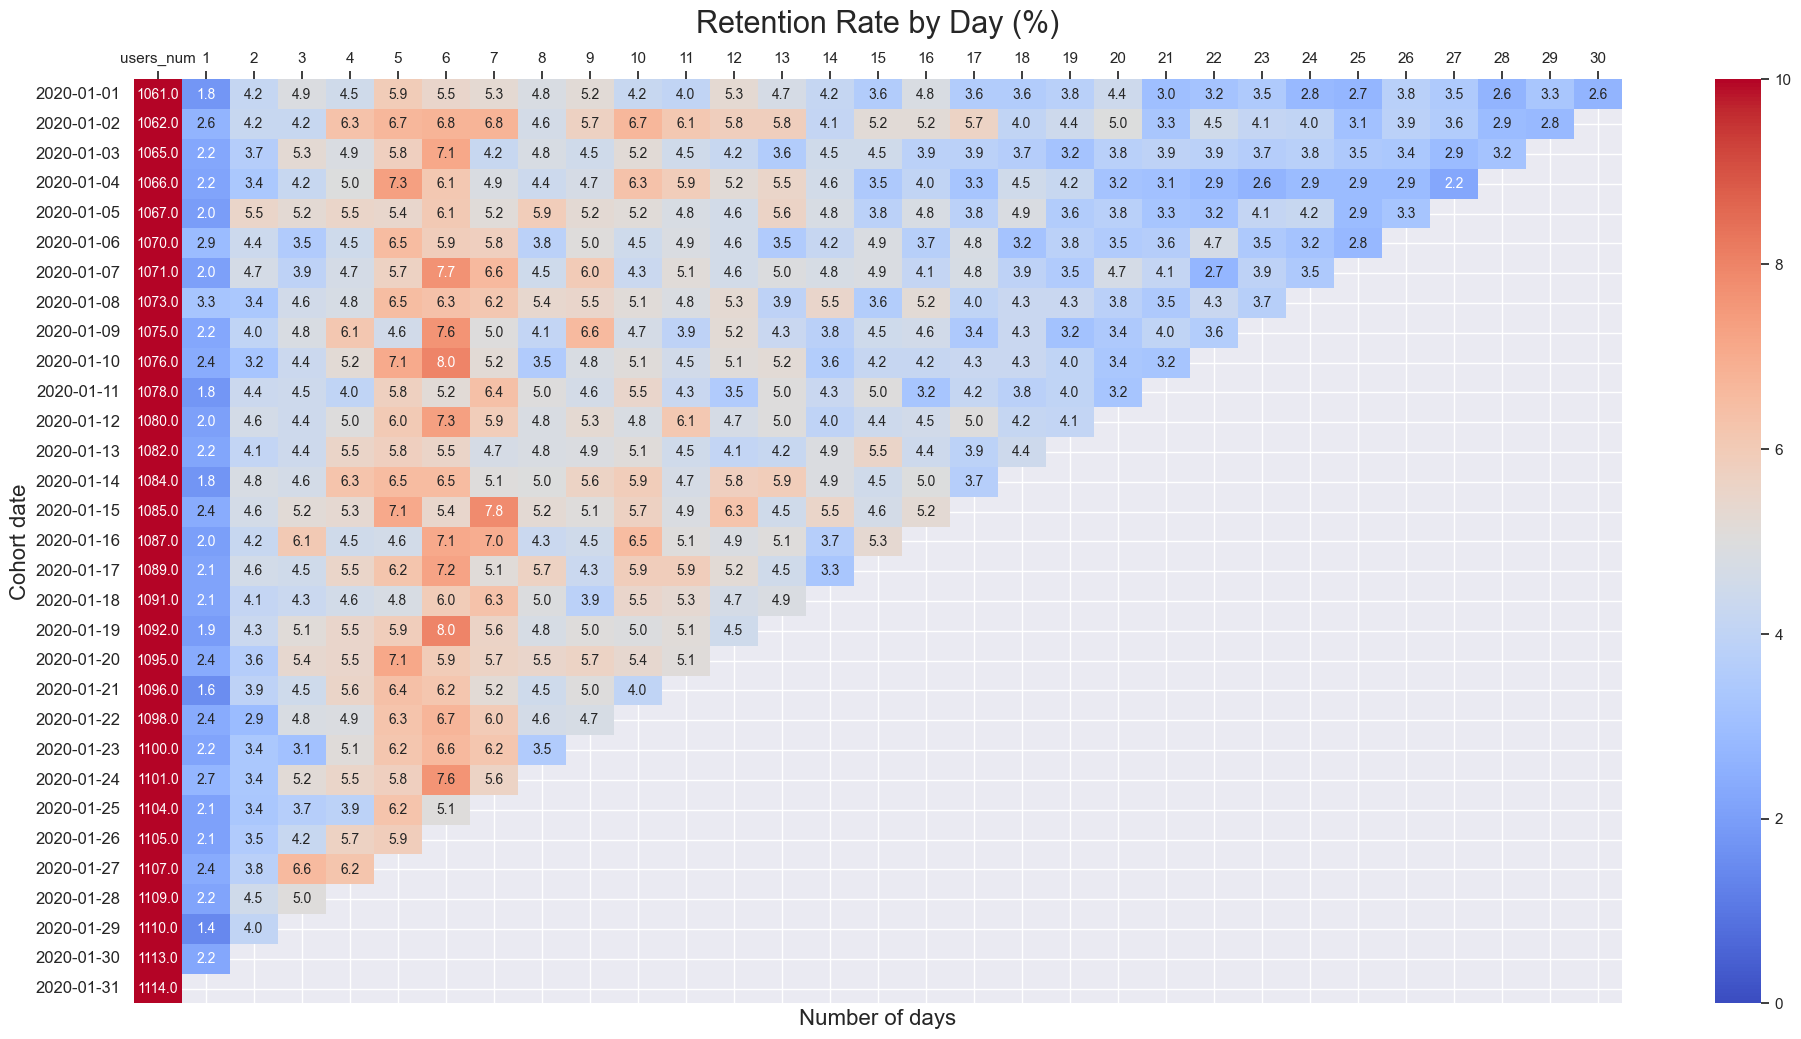

In [18]:
# вывожу и ретеншен как 30, так и 7 дней для наглядности
first_date = '2020-01-01' # пишу дату в формате год-месяц-день
ndays = 30 # задаю количество дней 
get_retention(reg_data, auth_data, first_date, ndays);

## Ключевые выводы и рекомендации:
1) Отмечен низкий Retention Rate с 1-го по 3-ий дни. После 30 дня RR стремится к 2.5%, после 35 дня к 2%
2) Заметен подъем на 5-7 дни и 10-12 дни. Возможно связано с наградами за вход, выполнение заданий в эти дни или уведомлениями.
3) Возможно, стоит внедрить награду за ежедневный вход в игру или за вход в игру несколько дней подряд.
4) Можно разработать ежедневное обучение в течение первой недели после регистрации, чтобы игроки разобрались и привыкли к игре.
5) Также возможно создать особый квест с подходящими наградами с 30 по 35 день, чтобы возрадить интерес игроков.
6) Можно высылать уведомления для участия в квесте с помощью доступного канала связи: email, discord, социальные сети и тд.